## 모듈 추가
----- 

In [1]:
import cv2, os
import matplotlib.pyplot as plt
import numpy as np
import dlib

## 얼굴인식하기
------


### 얼굴 이미지 불러오기

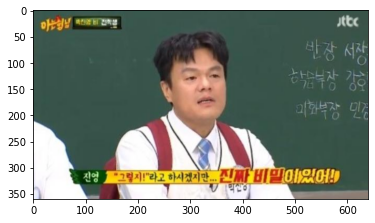

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/jyp1.jpg'
img_bgr = cv2.imread(my_image_path,cv2.IMREAD_UNCHANGED)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_show = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

# 이미지 RGB로 변경 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_show) 
plt.show()

### 이미지에서 얼굴인식하기

In [3]:
detector_hog = dlib.get_frontal_face_detector()

rectangles[[(270, 92) (378, 199)]]


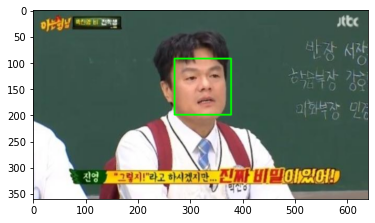

In [4]:
dlib_rects = detector_hog(img_show, 1)

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show,(l,t), (r,b), (0, 255,0), 2, lineType=cv2.LINE_AA)
    
plt.imshow(img_show)
plt.show()

### face landmark 모델 추가

In [5]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


### face landmark 생성 및 표현

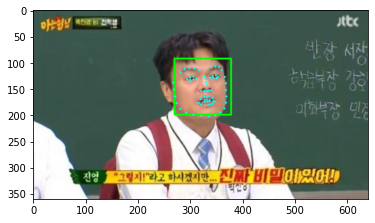

68


In [6]:
list_landmarks = []
# 사진에서 얼굴 인식하여 랜드마크 좌표 생성
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_show, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# 생성된 랜드마크를 사진 위에 표현
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

plt.imshow(img_show)
plt.show()    
print(len(list_landmarks[0]))

#### 랜드마크의 번호별 위치

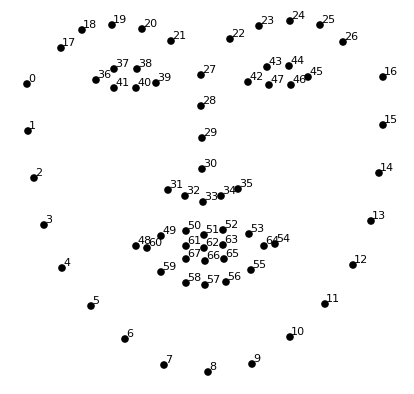

### 스티커 합성에 사용될 랜드마크 지정 

In [7]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    # 이미지 들어갈 랜드마크
    x_nose = landmark[33][0]
    y_nose = landmark[33][1]
    x_right = landmark[14][0]
    y_bottom = landmark[8][1]
    
    print(f'x_nose, y_nose: {x_nose, y_nose}')
    print(f'(x_right): {x_right }')
    print(f'(y_bottm): {y_bottom}')

x_nose, y_nose: (332, 154)
(x_right): 368
(y_bottm): 202


## 스티커 이미지에서 배경 제거 후 합성하기
-----

### 스티커 이미지 로드

48 36


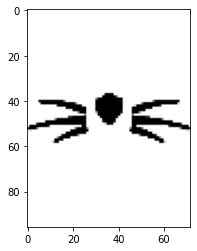

In [8]:
# 스티커 이미지 불러오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers2.png'
img_sticker = cv2.imread(sticker_path)

# 스티커 이미지 리사이징
half_x , half_y = x_right - x_nose, y_bottom - y_nose # 코 끝과 x 오른쪽 끝, y 아래쪽 끝 사이의 간격이 이미지 가로,세로의 절반이 됨
print(half_y, half_x)
img_sticker = cv2.resize(img_sticker, (half_x * 2, half_y * 2)) # 얼굴 인식 영역에 맞춰서 스티커크기 조정
plt.imshow(img_sticker)
plt.show()

> 스티커 이미지를 리사이징 할 때 **코끝이 합성될 이미지의 정중앙**에 위치하게 하기 위해
**rectangle.right() - 코의 x좌표**, 턱끝인 **랜드마크 8번의 y좌표 - 코의 y좌표** 를 한 후
각각의 값을 **2배**하여 **합성될 이미지의 x,y전체 길이로 설정**하였다.

### 스티커 영역 설정

(refind_x_left,right): (296, 368)
(refind_y_top,bottm): (106, 202)
sticker_area


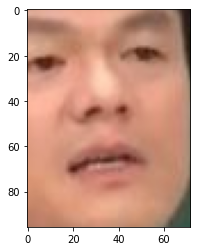

In [9]:
# sticker_area 설정: y,x순
refind_y_top = y_nose - half_y # 코의 x좌표에서 앞서 구한 합성될 이미지의 x축 절반의 길이를 빼서 x좌표 원점을 구한다.
refind_y_bottom = refind_y_top + img_sticker.shape[0] 
refind_x_left = x_nose - half_x # 코의 x좌표에서 앞서 구한 합성될 이미지의 y축 절반의 길이를 빼서 y좌표 원점을 구한다.
refind_x_right = refind_x_left + img_sticker.shape[1]
print(f'(refind_x_left,right): {refind_x_left, refind_x_right }')
print(f'(refind_y_top,bottm): {refind_y_top, refind_y_bottom}')

# img_rgb에서 sticker가 붙을 영역 지정하기
sticker_area = img_rgb[refind_y_top:refind_y_bottom, refind_x_left:refind_x_right]
print('sticker_area')
plt.imshow(sticker_area)
plt.show()

### 스티커이미지의 배경 제거후 스티커 영역에 합치기
* [gramman 0.1 documentation - 이미지연산](https://opencv-python.readthedocs.io/en/latest/doc/07.imageArithmetic/imageArithmetic.html) 참조
 

sticker_area


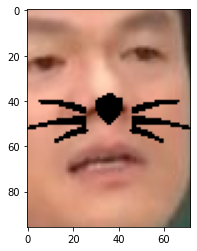

In [10]:
#mask를 만들기 위해서 img1을 gray로 변경 후, 
mask = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2GRAY)
#ret, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

#angle = math.atan(h/w)/math.pi*180
#mask

#bitwise_and 연산자는 둘다 0이 아닌 경우만 값을 통과 시킴.
#즉 mask가 검정색이 아닌 경우만 통과가 되기때문에 mask영역 이외는 모두 제거됨.
sticker_area = cv2.bitwise_and(sticker_area, sticker_area, mask=mask)

print('sticker_area')
plt.imshow(sticker_area)
plt.show()

### 스티커 영역을 원본 이미지에 합치기

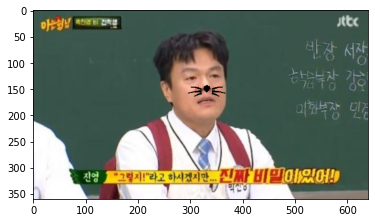

In [11]:
img_rgb[refind_y_top:refind_y_bottom, refind_x_left:refind_x_right] = np.where(sticker_area == 1, sticker_area, sticker_area).astype(np.uint8)
plt.imshow(img_rgb)
plt.show()

## 다른 조건으로 테스트
-----

### 1. 반대방향의 얼굴

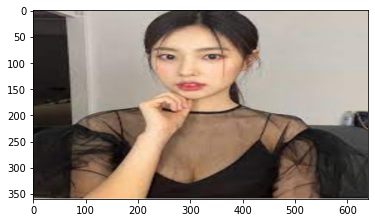

In [12]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/hyemmu2.jpeg'
img_bgr = cv2.imread(my_image_path,cv2.IMREAD_UNCHANGED)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show_hyem = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_show_hyem = cv2.cvtColor(img_show_hyem, cv2.COLOR_BGR2RGB)

# 이미지 RGB로 변경 
img_rgb_hyem = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_show_hyem) 
plt.show()

rectangles[[(225, 53) (354, 182)]]


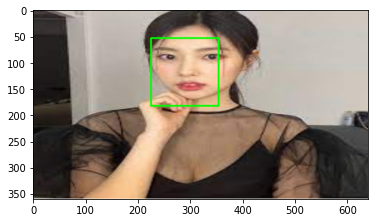

In [13]:
dlib_rects_hyem = detector_hog(img_show_hyem, 1)

print(dlib_rects_hyem)

for dlib_rect in dlib_rects_hyem:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show_hyem,(l,t), (r,b), (0, 255,0), 2, lineType=cv2.LINE_AA)
    
plt.imshow(img_show_hyem)
plt.show()

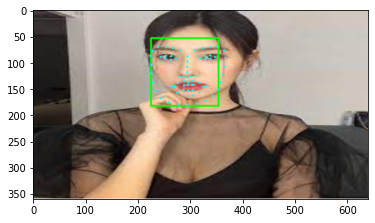

In [14]:
list_landmarks_hyem = []
# 사진에서 얼굴 인식하여 랜드마크 좌표 생성
for dlib_rect in dlib_rects_hyem:
    points = landmark_predictor(img_show_hyem, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks_hyem.append(list_points)

# 생성된 랜드마크를 사진 위에 표현
for landmark in list_landmarks_hyem:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show_hyem, point, 2, (0, 255, 255), -1) # yellow

plt.imshow(img_show_hyem)
plt.show()

x_nose, y_nose: (294, 128)
(x_right): 362
(y_bottm): 181
53 68


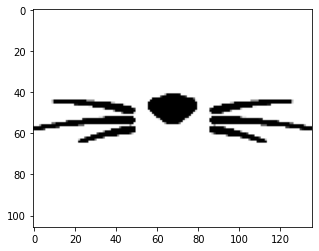

(refind_x_left,right): (226, 362)
(refind_y_top,bottm): (75, 181)
sticker_area


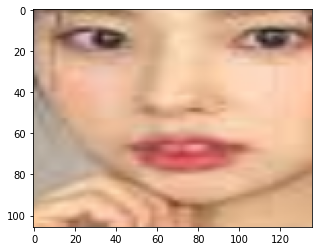

(96, 72, 3)


In [15]:
# 이미지 합성에 사용될 랜드마크 지정
for dlib_rects_hyem, list_landmarks_hyem  in zip(dlib_rects_hyem, list_landmarks_hyem):
    # 이미지 들어갈 랜드마크
    x_nose = landmark[33][0]
    y_nose = landmark[33][1]
    x_right = landmark[14][0]
    y_bottom = landmark[8][1]
    
    print(f'x_nose, y_nose: {x_nose, y_nose}')
    print(f'(x_right): {x_right }')
    print(f'(y_bottm): {y_bottom}')

# 스티커 이미지 불러오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers2.png'
img_sticker = cv2.imread(sticker_path)
    
# 스티커 이미지 리사이징
half_x , half_y = x_right - x_nose, y_bottom - y_nose # 코 끝과 x 오른쪽 끝, y 아래쪽 끝 사이의 간격이 이미지 가로,세로의 절반이 됨
print(half_y, half_x)
img_sticker = cv2.resize(img_sticker, (half_x * 2, half_y * 2)) # 얼굴 인식 영역에 맞춰서 스티커크기 조정
plt.imshow(img_sticker)
plt.show()
    
# sticker_area 설정: y,x순
refind_y_top = y_nose - half_y
refind_y_bottom = refind_y_top + img_sticker.shape[0] 
refind_x_left = x_nose - half_x
refind_x_right = refind_x_left + img_sticker.shape[1]
print(f'(refind_x_left,right): {refind_x_left, refind_x_right }')
print(f'(refind_y_top,bottm): {refind_y_top, refind_y_bottom}')

# img_rgb에서 sticker가 붙을 영역 지정하기
sticker_area_hyem = img_rgb_hyem[refind_y_top:refind_y_bottom, refind_x_left:refind_x_right]
print('sticker_area')
plt.imshow(sticker_area_hyem)
plt.show()
print(sticker_area.shape)

sticker_area_hyem


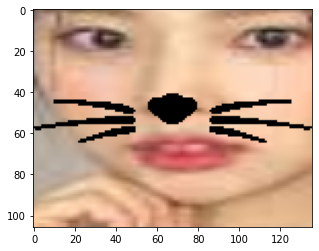

In [17]:
#mask를 만들기 위해서 img1을 gray로 변경
mask_hyem = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2GRAY)
#ret, mask_hyem = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)


#bitwise_and 연산자는 둘다 0이 아닌 경우만 값을 통과 시킴.
#즉 mask가 검정색이 아닌 경우만 통과가 되기때문에 mask영역 이외는 모두 제거됨.
sticker_area_hyem = cv2.bitwise_and(sticker_area_hyem, sticker_area_hyem, mask=mask_hyem)

print('sticker_area_hyem')
plt.imshow(sticker_area_hyem)
plt.show()

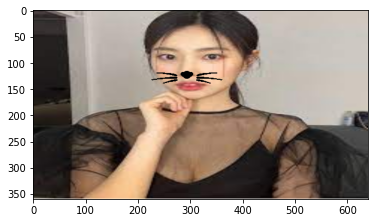

In [18]:
img_rgb_hyem[refind_y_top:refind_y_bottom, refind_x_left:refind_x_right] = np.where(sticker_area_hyem == 1, sticker_area_hyem, sticker_area_hyem).astype(np.uint8)
plt.imshow(img_rgb_hyem)
plt.show()

> rectangle의 영역이 실제 얼굴보다 좁게 인식되어 이미지의 x축이 줄어들었으나, 랜드마크를 사용한 좌표설정은 잘 동작하였다.

### 2. 기울어진 얼굴 + 클로즈 아웃

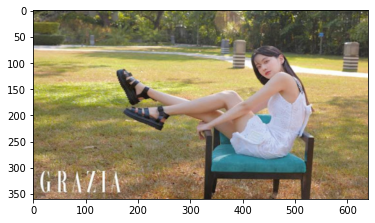

In [19]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/Ohyeon1.jpg'
img_bgr = cv2.imread(my_image_path,cv2.IMREAD_UNCHANGED)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show_oh = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_show_oh = cv2.cvtColor(img_show_oh, cv2.COLOR_BGR2RGB)

# 이미지 RGB로 변경 
img_rgb_oh = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_show_oh) 
plt.show()

rectangles[[(425, 94) (461, 130)]]


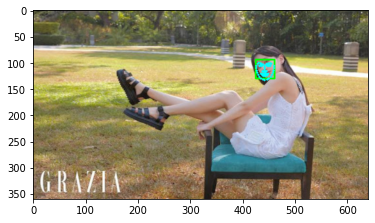

In [20]:
# 얼굴인식
dlib_rects = detector_hog(img_show_oh, 1)

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show_oh,(l,t), (r,b), (0, 255,0), 2, lineType=cv2.LINE_AA)
    
list_landmarks_oh = []

# 얼굴 랜드마크 좌표 생성
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_show_hyem, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks_oh.append(list_points)

    
# 생성된 랜드마크를 사진 위에 표현    
for landmark in list_landmarks_oh:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show_oh, point, 2, (0, 255, 255), -1) # yellow

plt.imshow(img_show_oh)
plt.show()

x_nose, y_nose: (442, 117)
(x_right): 459
(y_bottm): 133
16 17


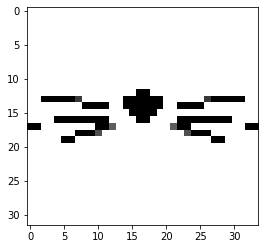

(refind_x_left,right): (425, 459)
(refind_y_top,bottm): (101, 133)
sticker_area


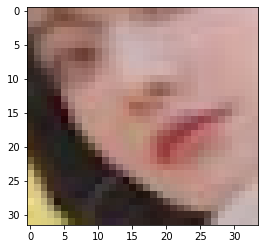

In [21]:
# 이미지 합성에 사용될 랜드마크 지정
for dlib_rect, list_landmarks_oh  in zip(dlib_rects, list_landmarks_oh ):
    # 이미지 들어갈 랜드마크
    x_nose = landmark[33][0]
    y_nose = landmark[33][1]
    x_right = landmark[14][0]
    y_bottom = landmark[8][1]
    
    print(f'x_nose, y_nose: {x_nose, y_nose}')
    print(f'(x_right): {x_right }')
    print(f'(y_bottm): {y_bottom}')

# 스티커 이미지 불러오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers2.png'
img_sticker = cv2.imread(sticker_path)    
    
# 스티커 이미지 리사이징
half_x , half_y = x_right - x_nose, y_bottom - y_nose # 코 끝과 x 오른쪽 끝, y 아래쪽 끝 사이의 간격이 이미지 가로,세로의 절반이 됨
print(half_y, half_x)
img_sticker = cv2.resize(img_sticker, (half_x * 2, half_y * 2)) # 얼굴 인식 영역에 맞춰서 스티커크기 조정
plt.imshow(img_sticker)
plt.show()
    
# sticker_area 설정: y,x순
refind_y_top = y_nose - half_y
refind_y_bottom = refind_y_top + img_sticker.shape[0] 
refind_x_left = x_nose - half_x
refind_x_right = refind_x_left + img_sticker.shape[1]
print(f'(refind_x_left,right): {refind_x_left, refind_x_right }')
print(f'(refind_y_top,bottm): {refind_y_top, refind_y_bottom}')

# img_rgb에서 sticker가 붙을 영역 지정하기
sticker_area_oh = img_rgb_oh[refind_y_top:refind_y_bottom, refind_x_left:refind_x_right]
print('sticker_area')
plt.imshow(sticker_area_oh)
plt.show()

sticker_area_oh


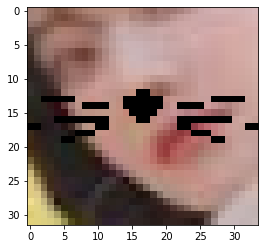

In [22]:
#mask를 만들기 위해서 이미지를 gray로 변경
mask_oh = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2GRAY)
#ret, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

#bitwise_and 연산자는 둘다 0이 아닌 경우만 값을 통과 시킴.
#즉 mask가 검정색이 아닌 경우만 통과가 되기때문에 mask영역 이외는 모두 제거됨.
sticker_area_oh = cv2.bitwise_and(sticker_area_oh, sticker_area_oh, mask=mask_oh)

print('sticker_area_oh')
plt.imshow(sticker_area_oh)
plt.show()

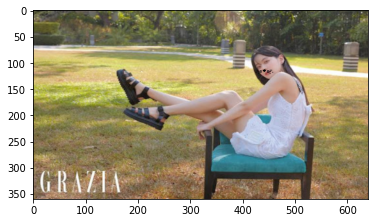

In [23]:
img_rgb_oh[refind_y_top:refind_y_bottom, refind_x_left:refind_x_right] = np.where(sticker_area_oh == 1, sticker_area_oh, sticker_area_oh).astype(np.uint8)
plt.imshow(img_rgb_oh)
plt.show()

> 얼굴이 기울어지고, 클로즈 아웃된 이미지에서도 코끝을 중심으로 한 좌표설정이 잘 작동하였다.

## 후기
-----

### 난관 1. 얼굴인식이 올바르게 적용되는 이미지를 수집하기

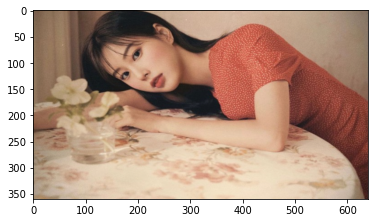

In [30]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/hyemmu1.png'
img_bgr = cv2.imread(my_image_path,cv2.IMREAD_UNCHANGED)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show1 = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_show1 = cv2.cvtColor(img_show1, cv2.COLOR_BGR2RGB)

# 원본이미지 RGB로 변경 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_show1) 
plt.show()

rectangles[]


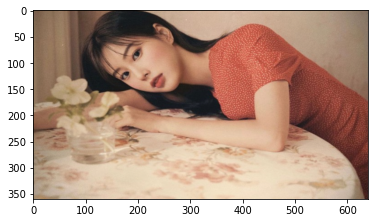

In [32]:
dlib_rects1 = detector_hog(img_show1, 1)

print(dlib_rects1)

for dlib_rect in dlib_rects1:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show1,(l,t), (r,b), (0, 255,0), 2, lineType=cv2.LINE_AA)
    
list_landmarks = []
# 사진에서 얼굴 인식하여 랜드마크 좌표 생성
for dlib_rect in dlib_rects1:
    points = landmark_predictor(img_show1, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show1, point, 2, (0, 255, 255), -1) # yellow

# 생성된 랜드마크를 사진 위에 표현
plt.imshow(img_show1)
plt.show()    

얼굴인식에 실패하여 rectangles 객체가 아무런 요소도 갖고 있지 않다.

#### 이처럼 수집한 이미지에 얼굴인식을 시도하다보면 여러가지 실패 케이스들이 발생했다.

1. 이미지 리사이징 과정에서 가로세로 비율 유지 실패
2. rectangles 객체 생성 실패
3. 얼굴이 아닌 위치에 rectangles 생성
4. 얼굴의 일부분에만 rectangles 생성

4.번의 경우 앞서 반대방향얼굴 인식 테스트에서처럼 이후의 작업에 지장이 없는 경우도 있었으나, 1~3번의 케이스는 그 이후의 단계로 전혀 진행할 수 없고, 4번의 경우도 높은 확률로 다음 단계로 진행할 수 없었다. 

이와 같은 실패 케이스에 해당하지 않는 정상적인 케이스를 찾는 것이 생각 이상으로 시간이 걸렸는데, 만약 **앞으로 있을 해커톤에서 얼굴인식을 활용한 어플리케이션을 개발하게 된다면 먼저 얼굴인식의 성공률을 높이기 위한 방안을 찾는 것부터 시작해야**할 것 같다. 이를 위해선 dlib.get_frontal_face_detector에 대한 확실한 이해가 필요할 것이다.

### 난관 2. 노드의 예제코드 이해하기

이번 노드에서는 예제코드의 의미를 이해하는데 매우 많은 시간을 할애했다.
특히 합성할 이미지의 기준점을 잡는 부분의 코드진행을 이해하는데 골머리를 앓았다.
한동안 헤맨 끝에 의미가 분명한 변수명을 새로 할당하는 것부터 시작해보니 조금씩 이해가 되기 시작했다.




